In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

/home/samarx/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-20 17:04:01.716649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 17:04:01.733569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 17:04:01.737116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 17:04:01.748607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is opti

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#df_org=pd.DataFrame(data)
df=pd.read_csv("/home/samarx/LLM/data3.csv" ,encoding="utf-8")

In [5]:
df

,text,action
0,consulter solde,Peux-tu m'indiquer le solde actuel de mon compte
1,consulter solde,Donne-moi une mise à jour de mon compte
2,consulter solde,Affiche le montant actuel de mon compte
3,consulter solde,Peux-tu vérifier combien il me reste actuelle...
4,consulter solde,Je veux savoir combien il me reste actuellement.
...,...,...
2640,virement ccp,Envoyer des fonds depuis mon CCP pour des frai...
2641,virement ccp,Faire un transfert pour des frais de mise à jo...
2642,virement ccp,Effectuer un virement pour des frais de gestio...
2643,virement ccp,Réaliser un transfert pour des frais de public...


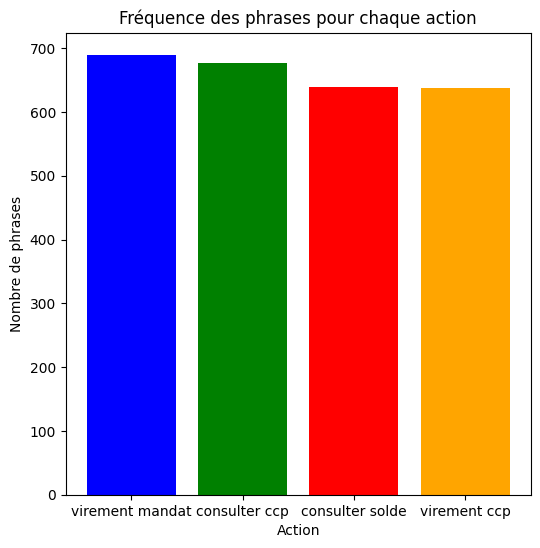

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculer les fréquences des actions
frequences = df['text'].value_counts()

# Extraire les actions et leurs fréquences
actions = frequences.index
valeurs = frequences.values

# Visualisation par histogramme
plt.figure(figsize=(6, 6))
plt.bar(actions, valeurs, color=['blue', 'green', 'red', 'orange'])

# Ajouter des labels et un titre
plt.xlabel('Action')
plt.ylabel('Nombre de phrases')
plt.title('Fréquence des phrases pour chaque action')

# Afficher l'histogramme
plt.show()


In [7]:
labels = df['text'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['consulter solde', 'virement mandat', 'consulter ccp', 'virement ccp']

In [8]:
NUM_LABELS= len(labels)
id2label={id:label for id, label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

print(id2label)
print(label2id)

{0: 'consulter solde', 1: 'virement mandat', 2: 'consulter ccp', 3: 'virement ccp'}
{'consulter solde': 0, 'virement mandat': 1, 'consulter ccp': 2, 'virement ccp': 3}


In [9]:
df['labels'] = pd.factorize(df.text)[0]
df

,text,action,labels
0,consulter solde,Peux-tu m'indiquer le solde actuel de mon compte,0
1,consulter solde,Donne-moi une mise à jour de mon compte,0
2,consulter solde,Affiche le montant actuel de mon compte,0
3,consulter solde,Peux-tu vérifier combien il me reste actuelle...,0
4,consulter solde,Je veux savoir combien il me reste actuellement.,0
...,...,...,...
2640,virement ccp,Envoyer des fonds depuis mon CCP pour des frai...,3
2641,virement ccp,Faire un transfert pour des frais de mise à jo...,3
2642,virement ccp,Effectuer un virement pour des frais de gestio...,3
2643,virement ccp,Réaliser un transfert pour des frais de public...,3


<Axes: ylabel='count'>

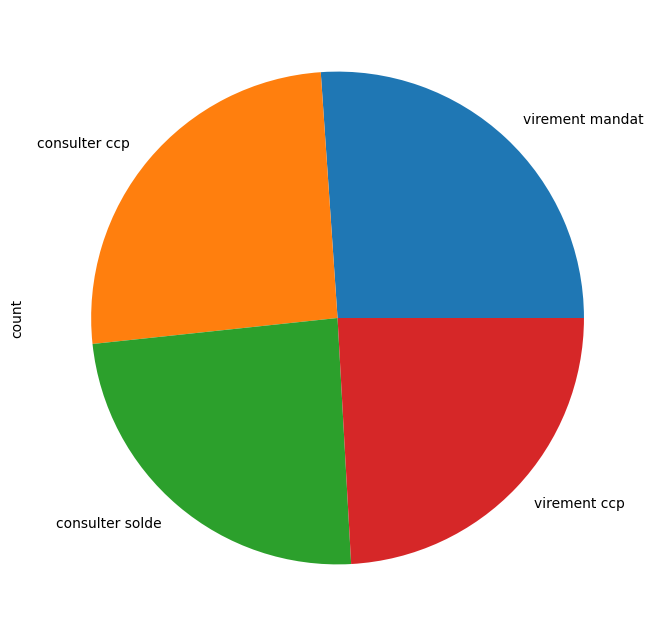

In [33]:
df.text.value_counts().plot(kind='pie', figsize=(,8))

In [11]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-uncased", max_length=512)

/home/samarx/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [15]:
train_df['action']

2464    Configurer un virement pour des frais de scola...
1399                  Affiche le solde de mon CCP actuel.
297         Quel est le solde de mon compte à l'instant ?
598      J'aimerais connaître le solde de mon compte é...
1647        Montre-moi les mouvements récents de mon CCP.
                              ...                        
1638     Peux-tu afficher les transactions de mon comp...
1095     Peux-tu me fournir une confirmation des frais...
1130     peux-tu m'expliquer comment demander un rembo...
1294     combien de temps faut-il pour qu'un virement ...
860      Peux-tu vérifier les informations de mon vire...
Name: action, Length: 1851, dtype: object

In [16]:
train_encodings = tokenizer(train_df['action'].tolist(), truncation=True, padding=True)
val_encodings  = tokenizer(val_df['action'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['action'].tolist(), truncation=True, padding=True)

In [17]:
train_labels=train_df['labels'].tolist()
test_labels=test_df['labels'].tolist()
val_labels=val_df['labels'].tolist()

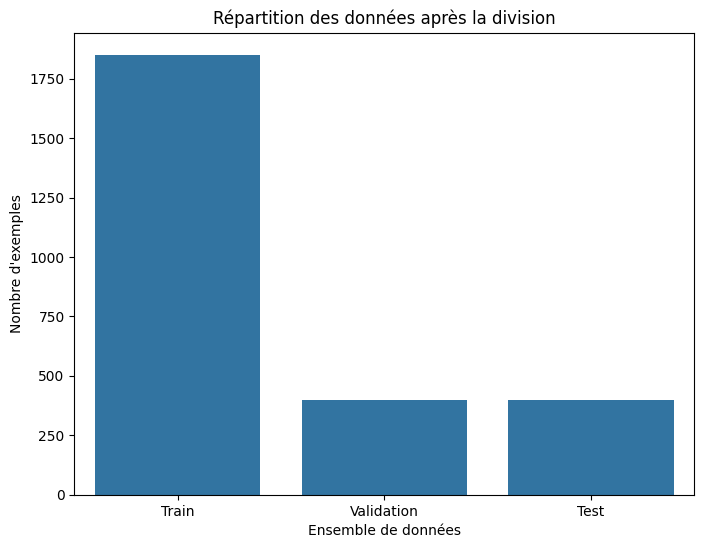

In [36]:
import matplotlib.pyplot as plt

split_data = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Count': [len(train_df), len(val_df), len(test_df)]
})

# Visualisation avec seaborn (barplot)
plt.figure(figsize=(8, 6))
sns.barplot(x='Dataset', y='Count', data=split_data)
plt.title('Répartition des données après la division')
plt.ylabel('Nombre d\'exemples')
plt.xlabel('Ensemble de données')
plt.show()


In [20]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [22]:
train_dataloader

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [24]:
val_dataloader

In [25]:
'''from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Arrêter après 2 évaluations sans amélioration
)

trainer.train()
'''

'from transformers import Trainer, TrainingArguments\nfrom transformers import EarlyStoppingCallback\n\ntraining_args = TrainingArguments(\n    output_dir=\'./TTC4900Model\',\n    do_train=True,\n    do_eval=True,\n    num_train_epochs=3,\n    per_device_train_batch_size=4,\n    warmup_steps=500,\n    weight_decay=0.01,\n    logging_strategy=\'steps\',\n    logging_dir=\'./multi-class-logs\',\n    logging_steps=100,\n    evaluation_strategy="steps",\n    eval_steps=100,\n    save_strategy="steps",\n    fp16=False,\n    load_best_model_at_end=True,\n)\n\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataloader,\n    eval_dataset=val_dataloader,\n    compute_metrics=compute_metrics,\n    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Arrêter après 2 évaluations sans amélioration\n)\n\ntrainer.train()\n'

In [26]:
from transformers import Trainer
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./TTC4900Model',      # Dossier de sortie pour sauvegarder le modèle
    do_train=True,                    # Effectuer l'entraînement
    do_eval=True,                     # Effectuer l'évaluation
    learning_rate=5e-5,               # Réduction du taux d'apprentissage
    num_train_epochs=3,               # Réduire le nombre d'époques pour éviter l'overfitting
    per_device_train_batch_size=8,    # Augmenter la taille du batch si possible
    warmup_steps=100,                 # Réduire les steps de warmup
    weight_decay=0.01,                # Garder la régularisation
    logging_strategy='steps',         # Stratégie de logging par steps
    logging_dir='./multi-class-logs', # Répertoire pour TensorBoard
    logging_steps=100,                # Logging toutes les 100 steps
    evaluation_strategy="steps",      # Évaluation par steps
    eval_steps=100,                   # Evaluation toutes les 100 steps
    save_strategy="steps",            # Sauvegarder par steps
    fp16=True,                        # Activer la précision mixte pour accélérer l'entraînement si GPU le supporte
    load_best_model_at_end=True,      # Charger le meilleur modèle à la fin
    save_total_limit=2                # Limiter le nombre de checkpoints sauvegardés

)
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)
trainer.train()

/home/samarx/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/samarx/.local/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.743500,0.042397,0.989924,0.989886,0.989886,0.989886
200,0.082500,0.044456,0.989924,0.989944,0.989707,0.990430
300,0.041900,0.032804,0.994962,0.994944,0.994902,0.995037
400,0.020000,0.046623,0.992443,0.992389,0.992513,0.992290
500,0.019100,0.017831,0.997481,0.997449,0.997283,0.997642
600,0.008600,0.017478,0.997481,0.997449,0.997283,0.997642


TrainOutput(global_step=696, training_loss=0.13395065737181697, metrics={'train_runtime': 182.2045, 'train_samples_per_second': 30.477, 'train_steps_per_second': 3.82, 'total_flos': 94171296067992.0, 'train_loss': 0.13395065737181697, 'epoch': 3.0})

In [38]:
q=[trainer.evaluate(eval_dataset=test_dataset) for df in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"])

# Évaluation sur l'ensemble de validation val_results = trainer.evaluate(eval_dataset=val_dataloader)

# Évaluation sur l'ensemble de test test_results = trainer.evaluate(eval_dataset=test_dataset)

# Création d'un DataFrame avec les résultats results_df = pd.DataFrame([val_results, test_results], index=["val", "test"])

#results_df.iloc[:,:5]  # Pour afficher les premières 5 colonnes des résultats



,eval_loss,eval_model_preparation_time,eval_Accuracy,eval_F1,eval_Precision,eval_Recall,eval_runtime,eval_samples_per_second,eval_steps_per_second
train,0.012881,0.0047,0.997481,0.997542,0.997685,0.997423,1.6970,233.938,29.463
val,0.012881,0.0047,0.997481,0.997542,0.997685,0.997423,1.6044,247.447,31.165
test,0.012881,0.0047,0.997481,0.997542,0.997685,0.997423,1.5998,248.160,31.254


In [28]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)

    # Get the index of the class with the highest probability
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    pred_label = model.config.id2label[pred_label_idx.item()]

    return pred_label

# Example usage:
text = "je veux consulter ccp"

print(predict(text))


consulter ccp


In [29]:
from transformers import Trainer

# Assurez-vous que `model` et `training_args` sont définis comme dans votre code
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

# Évaluer sur les données de test
results = trainer.evaluate(eval_dataset=test_dataset)

# Afficher les résultats
print("Evaluation results:", results)


/home/samarx/.local/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Evaluation results: {'eval_loss': 0.012881183065474033, 'eval_model_preparation_time': 0.0047, 'eval_Accuracy': 0.9974811083123426, 'eval_F1': 0.9975418725147608, 'eval_Precision': 0.9976851851851851, 'eval_Recall': 0.9974226804123711, 'eval_runtime': 1.5734, 'eval_samples_per_second': 252.317, 'eval_steps_per_second': 31.778}


In [30]:
results

{'eval_loss': 0.012881183065474033,
 'eval_model_preparation_time': 0.0047,
 'eval_Accuracy': 0.9974811083123426,
 'eval_F1': 0.9975418725147608,
 'eval_Precision': 0.9976851851851851,
 'eval_Recall': 0.9974226804123711,
 'eval_runtime': 1.5734,
 'eval_samples_per_second': 252.317,
 'eval_steps_per_second': 31.778}

In [31]:
import torch
from torch.nn.functional import softmax

# Initialiser des listes pour stocker les logits et les labels
all_logits = []
all_labels = []

# Ne pas calculer les gradients pour l'évaluation
with torch.no_grad():
    for batch in test_dataset:  # Utiliser le dataloader et non directement le dataset
        # Si le batch est un dictionnaire, on extrait 'input_ids' et 'labels'
        inputs = batch['input_ids']
        labels = batch['labels']
        
        # Obtenez les prédictions (logits) du modèle
        logits = model(inputs)
        
        # Stocker les logits et les labels
        all_logits.append(logits)
        all_labels.append(labels)

# Convertir les logits et les labels en tensors
all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

# Appliquer softmax pour obtenir les probabilités
test_predictions_proba = softmax(all_logits, dim=1).numpy()

# Calculer la courbe ROC pour chaque classe
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = test_predictions_proba.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels.numpy(), test_predictions_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la courbe ROC pour chaque classe
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


IndexError: too many indices for tensor of dimension 1

In [36]:
phrases = [
    "Virement permanent sur un CCP",
    "Montre-moi les dernières transactions sur mon CCP.",
    "Peux-tu me montrer le solde de mon CCP maintenant ?",
    "Je vais faire un virement mandat pour un paiement important.",
]

# Liste pour stocker les résultats
results = []

# Prédiction et ajout des résultats à la liste
for phrase in phrases:
    category = predict(phrase)
    results.append({'Phrase': phrase, 'Catégorie': category})

# Création du DataFrame à partir des résultats
df_results = pd.DataFrame(results)

# Affichage du tableau
df_results

,Phrase,Catégorie
0,Virement permanent sur un CCP,virement ccp
1,Montre-moi les dernières transactions sur mon ...,consulter ccp
2,Peux-tu me montrer le solde de mon CCP mainten...,consulter ccp
3,Je vais faire un virement mandat pour un paiem...,virement mandat


In [33]:
# Test with a an example of text written on the chatbot
text2 = "Je souhaite virement de mon CCP à mon compte à vue."
# "Machine Learning itself is moving towards more and more automated"
predict(text2)

'consulter ccp'

In [ ]:
# Test with a an example of text written on the chatbot
text3 = "I want to create a project"
# "Machine Learning itself is moving towards more and more automated"
predict(text3)

(tensor([[0.2290, 0.2878, 0.2656, 0.2175]], grad_fn=<SoftmaxBackward0>),
 tensor(1),
 'create_project')

In [38]:
# Test with a an example of text written on the chatbot
text4 = "Helllo"
# "Machine Learning itself is moving towards more and more automated"
predict(text4)

'consulter solde'

In [37]:
# Supposons que "model" soit votre modèle entraîné
torch.save(trainer.model.state_dict(), "/home/samarx/LLM/model.pth")

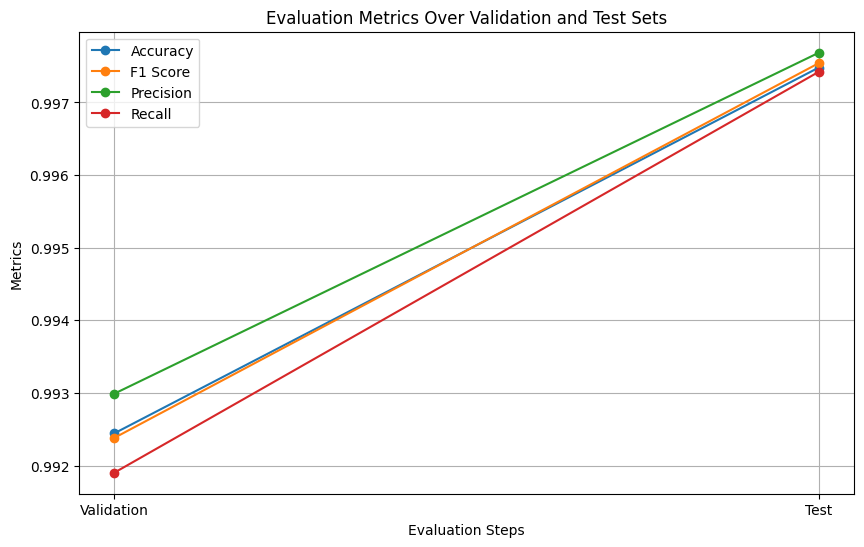

In [43]:
import matplotlib.pyplot as plt

# Résultats d'évaluation
val_results = trainer.evaluate(eval_dataset=val_dataloader)
test_results = trainer.evaluate(eval_dataset=test_dataset)

# Récupération des métriques des résultats
accuracies = [val_results.get('eval_Accuracy', 0), test_results.get('eval_Accuracy', 0)]
f1_scores = [val_results.get('eval_F1', 0), test_results.get('eval_F1', 0)]
precisions = [val_results.get('eval_Precision', 0), test_results.get('eval_Precision', 0)]
recalls = [val_results.get('eval_Recall', 0), test_results.get('eval_Recall', 0)]

# Étapes correspondant aux évaluations (par exemple validation et test)
steps = ['Validation', 'Test']

# Tracer les courbes
plt.figure(figsize=(10, 6))

plt.plot(steps, accuracies, label="Accuracy", marker='o')
plt.plot(steps, f1_scores, label="F1 Score", marker='o')
plt.plot(steps, precisions, label="Precision", marker='o')
plt.plot(steps, recalls, label="Recall", marker='o')

plt.xlabel('Evaluation Steps')
plt.ylabel('Metrics')
plt.title('Evaluation Metrics Over Validation and Test Sets')
plt.legend()
plt.grid(True)
plt.show()


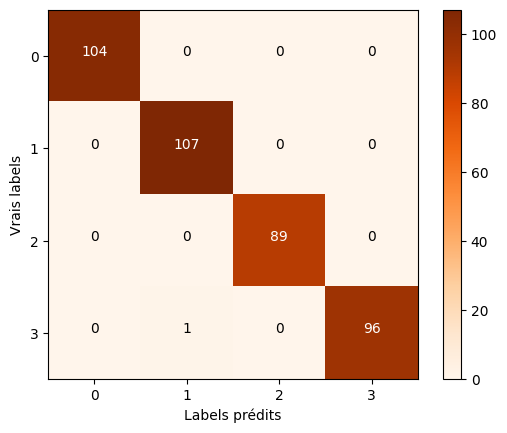

Valeurs de TN, FP, FN, TP : 
 [104   0   0   0] [  0 107   0   0] [ 0  0 89  0] [ 0  1  0 96]
Rapport de Classification  : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       0.99      1.00      1.00       107
           2       1.00      1.00      1.00        89
           3       1.00      0.99      0.99        97

    accuracy                           1.00       397
   macro avg       1.00      1.00      1.00       397
weighted avg       1.00      1.00      1.00       397



In [44]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions_and_labels(trainer, dataloader):
    # Exécuter le modèle sur le dataloader
    outputs = trainer.predict(dataloader)
    predictions = np.argmax(outputs.predictions, axis=-1)
    labels = outputs.label_ids
    return labels, predictions



# Obtenir les étiquettes vraies et prédites pour l'ensemble de test
test_labels, test_predictions = get_predictions_and_labels(trainer, test_dataset)

# confusion matrix
cnf_matrix = confusion_matrix(test_labels, test_predictions)
#print('Matrice de confusion : \n',cnf_matrix)

classes = range(0,4)
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Oranges')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

# outcome values order in sklearn
tn, fp, fn ,tp = confusion_matrix(test_labels, test_predictions)
print('Valeurs de TN, FP, FN, TP : \n',tn, fp, fn, tp)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(test_labels,test_predictions)
print('Rapport de Classification  : \n',matrix)

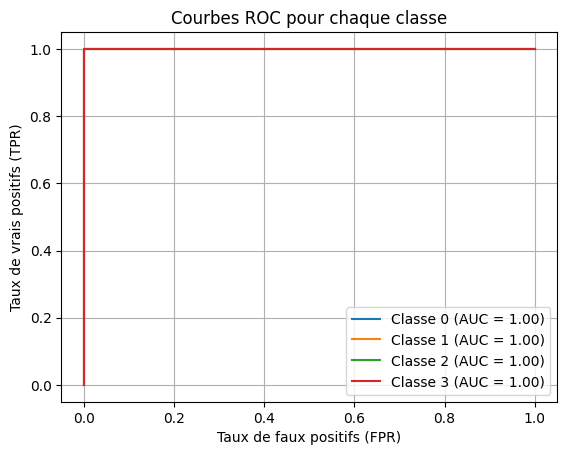

In [45]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

# Fonction pour obtenir les probabilités et les étiquettes
def get_predictions_and_labels(trainer, dataloader):
    outputs = trainer.predict(dataloader)
    logits = outputs.predictions
    labels = outputs.label_ids
    probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    return labels, probabilities

# Obtenir les étiquettes vraies et les probabilités pour l'ensemble de test
testy, lr_probs = get_predictions_and_labels(trainer, test_dataset)

# Calculer et afficher les AUC pour chaque classe
for i in range(lr_probs.shape[1]):
    # Calculer la courbe ROC pour chaque classe
    fpr, tpr, _ = roc_curve(testy, lr_probs[:, i], pos_label=i)
    auc = roc_auc_score(testy == i, lr_probs[:, i])
    
    # Tracer la courbe ROC
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {auc:.2f})')

# Ajouter des labels et une légende
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC pour chaque classe')
plt.legend()
plt.grid()
plt.show()


In [42]:
# Calculer la matrice de confusion pour la validation et le test
val_cm = confusion_matrix(val_labels, val_predictions)
test_cm = confusion_matrix(test_labels, test_predictions)


In [46]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  xticklabels=["consulter solde", "virement mandat", "consulter ccp", "virement ccp"], yticklabels=["consulter solde", "virement mandat", "consulter ccp", "virement ccp"])
    plt.xlabel('Prédictions')
    plt.ylabel('Véritables Étiquettes')
    plt.title(title)
    plt.show()

# Afficher la matrice de confusion pour l'ensemble de validation
plot_confusion_matrix(val_cm, title='Validation Confusion Matrix')

# Afficher la matrice de confusion pour l'ensemble de test
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')


NameError: name 'val_cm' is not defined

In [47]:
import pandas as pd

# Créez un DataFrame pour les erreurs
errors = pd.DataFrame({
    'Étiquette Vraie': test_labels,
    'Prédiction': test_predictions
})

# Trouvez les erreurs de classification
erreurs_de_classification = errors[errors['Étiquette Vraie'] != errors['Prédiction']]

print("Exemples d'erreurs de classification :")
print(erreurs_de_classification)


Exemples d'erreurs de classification :
     Étiquette Vraie  Prédiction
169                3           1
